# 曾正豪 0716325

In [9]:
import csv
import numpy as np

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data Input & Data Preprocessing
在資料讀取這邊，我使用了python的csv檔案讀取功能，將檔案內的資料一行一行讀取出來，並將每一行的各個feature提取出來將其放入x以及y中。

In [10]:
x = []
y = []

with open('ionosphere.data', newline='') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        y.append(row[-1])
        x.append(row[:-1])
        
x = np.array(x).astype(float)
y = np.array(y)

X_sparse = coo_matrix(x)
x, X_sparse, y = shuffle(x, X_sparse, y, random_state=0)

## Train-Test-Split
使用了```train_test_split```切出7:3的訓練集與測試集

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)

## You need to use linear, polynomial, RBF kernels to construct three different models
在這部分，我使用了linear, polynomial, RBF 3種不同的kernel在SVM上，同時其他的超參數保持預設值，這邊可以看到RBF的準確性是最佳的
### linear kernel

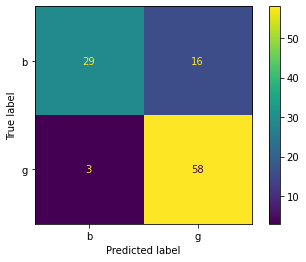

              precision    recall  f1-score   support

           b       0.91      0.64      0.75        45
           g       0.78      0.95      0.86        61

    accuracy                           0.82       106
   macro avg       0.85      0.80      0.81       106
weighted avg       0.84      0.82      0.81       106



In [12]:
svm = SVC(kernel='linear')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=svm.classes_).plot()
plt.show()
print(report)

### polynomial kernel

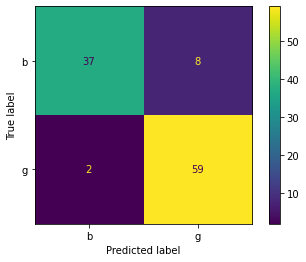

              precision    recall  f1-score   support

           b       0.95      0.82      0.88        45
           g       0.88      0.97      0.92        61

    accuracy                           0.91       106
   macro avg       0.91      0.89      0.90       106
weighted avg       0.91      0.91      0.90       106



In [13]:
svm = SVC(kernel='poly')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=svm.classes_).plot()
plt.show()
print(report)

### RBF kernel

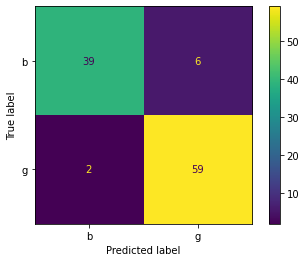

              precision    recall  f1-score   support

           b       0.95      0.87      0.91        45
           g       0.91      0.97      0.94        61

    accuracy                           0.92       106
   macro avg       0.93      0.92      0.92       106
weighted avg       0.93      0.92      0.92       106



In [14]:
svm = SVC(kernel='rbf')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=svm.classes_).plot()
plt.show()
print(report)

## Parameter Search
在這邊，我先將我想要設置的超參數用list存起來，然後使用3層for迴圈來對模型做grid search。對於每一組超參數，我使用train set做成的5-fold cross-validation來測試，並保留最佳的一組參數

Polynomial kernel SVM with hyperparameters degree=0, gamma=scale, coef0=0.0
and its accuracy is 0.5918367346938775.
              precision    recall  f1-score   support

           b       0.00      0.00      0.00       100
           g       0.59      1.00      0.74       145

    accuracy                           0.59       245
   macro avg       0.30      0.50      0.37       245
weighted avg       0.35      0.59      0.44       245

Polynomial kernel SVM with hyperparameters degree=0, gamma=scale, coef0=1.0
and its accuracy is 0.5918367346938775.
              precision    recall  f1-score   support

           b       0.00      0.00      0.00       100
           g       0.59      1.00      0.74       145

    accuracy                           0.59       245
   macro avg       0.30      0.50      0.37       245
weighted avg       0.35      0.59      0.44       245

Polynomial kernel SVM with hyperparameters degree=0, gamma=scale, coef0=3.0
and its accuracy is 0.5918367346938775

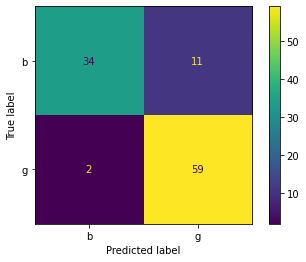

              precision    recall  f1-score   support

           b       0.94      0.76      0.84        45
           g       0.84      0.97      0.90        61

    accuracy                           0.88       106
   macro avg       0.89      0.86      0.87       106
weighted avg       0.89      0.88      0.87       106



In [15]:
degrees = [0,1,2,3,4,5,6,7,8,9]
gammas = ['scale', 'auto', 1.0/1, 1.0/2, 1.0/3, 1.0/4, 1.0/5, 1.0/6, 1.0/7 ]
coef0s = [0.0, 1.0, 3.0, 5.0, 10.0]

best_hyperpara = {}
highest_acc = 0

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

for degree in degrees:
    for gamma in gammas:
        for coef0 in coef0s:
            svm = SVC(gamma=gamma, kernel='poly', degree=degree, coef0=coef0)

            true_class = []
            pred_class = []
            CM_list = np.zeros((2,2)).astype(int)
            for train_index, test_index in kf.split(X_train):
                X_train_kfold, X_test_kfold = x[train_index], x[test_index]
                y_train_kfold, y_test_kfold = y[train_index], y[test_index]

                svm.fit(X_train_kfold, y_train_kfold)
                y_pred = svm.predict(X_test_kfold)

                true_class.extend(y_test_kfold)
                pred_class.extend(y_pred)

                CM = confusion_matrix(y_test_kfold, y_pred, labels=svm.classes_)
                CM_list += CM
            accuracy = accuracy_score(true_class, pred_class)
            print(f"Polynomial kernel SVM with hyperparameters degree={degree}, gamma={gamma}, coef0={coef0}\nand its accuracy is {accuracy}.")
            CM_list = CM_list // 5
            report = classification_report(true_class, pred_class)
            print(report)
            '''ConfusionMatrixDisplay(confusion_matrix=CM_list, display_labels=svm.classes_).plot()
            plt.show()'''
            if accuracy > highest_acc:
                highest_acc = accuracy
                best_hyperpara['degree'] = degree
                best_hyperpara['gamma'] = gamma
                best_hyperpara['coef0'] = coef0

print(f"\n\nThe best hyperparameters of polynomial kernel SVM is {best_hyperpara} with accuracy = {highest_acc}.\nReconstruct it and use the test set to show the result.")
svm = SVC(gamma=best_hyperpara['gamma'], kernel='poly', degree=best_hyperpara['degree'], coef0=best_hyperpara['coef0'])

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=svm.classes_).plot()
plt.show()
print(report)



在這邊，我先將我想要設置的超參數用list存起來，然後使用for迴圈來對模型做grid search。對於每一組超參數，我使用train set做成的5-fold cross-validation來測試，並保留最佳的一組參數

RBF SVM with hyperparameters gamma=scale,and its accuracy is 0.9387755102040817.
              precision    recall  f1-score   support

           b       0.96      0.89      0.92       100
           g       0.93      0.97      0.95       145

    accuracy                           0.94       245
   macro avg       0.94      0.93      0.94       245
weighted avg       0.94      0.94      0.94       245

RBF SVM with hyperparameters gamma=auto,and its accuracy is 0.9061224489795918.
              precision    recall  f1-score   support

           b       0.95      0.81      0.88       100
           g       0.88      0.97      0.92       145

    accuracy                           0.91       245
   macro avg       0.92      0.89      0.90       245
weighted avg       0.91      0.91      0.90       245

RBF SVM with hyperparameters gamma=1.0,and its accuracy is 0.8938775510204081.
              precision    recall  f1-score   support

           b       0.81      0.96      0.88       1

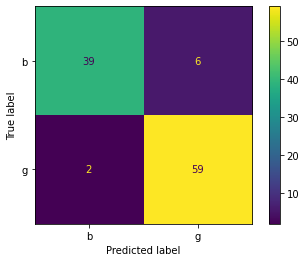

              precision    recall  f1-score   support

           b       0.95      0.87      0.91        45
           g       0.91      0.97      0.94        61

    accuracy                           0.92       106
   macro avg       0.93      0.92      0.92       106
weighted avg       0.93      0.92      0.92       106



In [16]:
gammas = ['scale', 'auto', 1.0/1, 1.0/2, 1.0/3, 1.0/4, 1.0/5, 1.0/6, 1.0/7, 1.0/8, 1.0/9, 1.0/10, 1.0/11 ]

best_hyperpara = {}
highest_acc = 0

kf = KFold(n_splits=5)
kf.get_n_splits(x)

for gamma in gammas:

    svm = SVC(gamma=gamma, kernel='rbf')

    true_class = []
    pred_class = []
    CM_list = np.zeros((2,2)).astype(int)
    for train_index, test_index in kf.split(X_train):
        X_train_kfold, X_test_kfold = x[train_index], x[test_index]
        y_train_kfold, y_test_kfold = y[train_index], y[test_index]

        svm.fit(X_train_kfold, y_train_kfold)
        y_pred = svm.predict(X_test_kfold)

        true_class.extend(y_test_kfold)
        pred_class.extend(y_pred)

        CM = confusion_matrix(y_test_kfold, y_pred, labels=svm.classes_)
        CM_list += CM
    accuracy = accuracy_score(true_class, pred_class)
    print(f"RBF SVM with hyperparameters gamma={gamma},and its accuracy is {accuracy}.")
    CM_list = CM_list // 5
    report = classification_report(true_class, pred_class)
    print(report)
    '''ConfusionMatrixDisplay(confusion_matrix=CM_list, display_labels=svm.classes_).plot()
    plt.show()'''
    if accuracy > highest_acc:
        highest_acc = accuracy
        best_hyperpara['gamma'] = gamma

print(f"\n\nThe best hyperparameters of RBF SVM is {best_hyperpara} with accuracy = {highest_acc}.\nReconstruct it and use Holdout validation with the ratio of 7:3 to show the result.")
svm = SVC(gamma=best_hyperpara['gamma'], kernel='rbf')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=svm.classes_).plot()
plt.show()
print(report)



# Questions
## Support Vector Machine
### Show the average performance of K-fold cross-validation of parameter search in tables for each kernel.
    已列於上方之Parameter Search部分